In [5]:
# THE TRULY IDEMPOTENT GRAND FINALE SCRIPT

import pandas as pd
from sqlalchemy import create_engine, text
import os
from datetime import date

# --- KONEKSI ---
db_user = 'postgres'; db_password = 'ardiwinata230803'; db_host = 'localhost'; db_port = '5432'; db_name = 'adventureworks_st'
connection_string = f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(connection_string)
print("✅ Koneksi ke database Data Warehouse berhasil!")

# --- Definisikan Nama Kolom Manual ---
pelanggan_cols = ['id_pelanggan', 'nama_depan', 'nama_belakang', 'email', 'kota_asal']
produk_cols = ['id_produk', 'nama_produk', 'subkategori', 'kategori', 'harga_standar', 'warna', 'lini_produk']
penjualan_cols = ['id_order', 'id_order_detail', 'tanggal_order', 'id_pelanggan', 'id_produk', 'jumlah_barang', 'harga_satuan', 'total_harga']

# --- FUNGSI RESET ---
def reset_all_tables():
    """Mengosongkan semua tabel DWH sebelum diisi ulang."""
    print("\n--- MERESET SEMUA TABEL DI DATA WAREHOUSE ---")
    with engine.connect() as connection:
        # Kita TRUNCATE tabel dalam urutan terbalik dari dependensi FOREIGN KEY
        # Atau gunakan CASCADE untuk memaksa penghapusan berantai
        connection.execute(text('TRUNCATE TABLE "Fakta_Penjualan" CASCADE;'))
        connection.execute(text('TRUNCATE TABLE "Dim_Pelanggan" CASCADE;'))
        connection.execute(text('TRUNCATE TABLE "Dim_Produk" CASCADE;'))
        connection.execute(text('TRUNCATE TABLE "Dim_Lokasi" CASCADE;'))
        connection.execute(text('TRUNCATE TABLE "Dim_Waktu" CASCADE;'))
        connection.commit()
    print("✅ Semua tabel berhasil dikosongkan.")

# --- FUNGSI-FUNGSI ETL ---
# (Semua fungsi etl_... dari script sebelumnya tetap sama persis di sini)
# Ainin singkat saja, tapi di kodemu copy-paste semua fungsi etl yang tadi ya.
def etl_pelanggan_scd2():
    # ... (logika lengkap SCD Tipe 2 seperti sebelumnya) ...
    print("\n--- Memulai ETL SCD Tipe 2 untuk Dim_Pelanggan ---")
    source_df = pd.read_csv(os.path.join('data_raw', 'raw_pelanggan.csv'), sep=',', header=None, skiprows=1, names=pelanggan_cols)
    source_df['nama_lengkap'] = source_df['nama_depan'] + ' ' + source_df['nama_belakang']
    try:
        dwh_df = pd.read_sql_query('SELECT * FROM "Dim_Pelanggan" WHERE status_sekarang = TRUE', engine)
    except:
        dwh_df = pd.DataFrame() # Jika tabel kosong dan error
    merged_df = pd.merge(source_df, dwh_df, on='id_pelanggan', how='left', suffixes=('_new', '_old'), indicator=True)
    new_records = merged_df[merged_df['_merge'] == 'left_only']; new_to_insert = new_records[['id_pelanggan', 'nama_lengkap_new', 'email_new', 'kota_asal_new']].copy(); new_to_insert.rename(columns={'nama_lengkap_new': 'nama_lengkap', 'email_new': 'email', 'kota_asal_new': 'kota_asal'}, inplace=True); new_to_insert['tanggal_mulai'] = date.today(); new_to_insert['tanggal_akhir'] = '9999-12-31'; new_to_insert['status_sekarang'] = True
    changed_df = merged_df[merged_df['_merge'] == 'both']; changed_df = changed_df[changed_df['kota_asal_new'] != changed_df['kota_asal_old']]; keys_to_expire = changed_df['pelanggan_key'].astype(int).tolist() if not changed_df.empty else []
    updates_as_new = changed_df[['id_pelanggan', 'nama_lengkap_new', 'email_new', 'kota_asal_new']].copy(); updates_as_new.rename(columns={'nama_lengkap_new': 'nama_lengkap', 'email_new': 'email', 'kota_asal_new': 'kota_asal'}, inplace=True); updates_as_new['tanggal_mulai'] = date.today(); updates_as_new['tanggal_akhir'] = '9999-12-31'; updates_as_new['status_sekarang'] = True
    records_to_insert = pd.concat([new_to_insert, updates_as_new], ignore_index=True)
    with engine.connect() as connection:
        if keys_to_expire:
            connection.execute(text(f"""UPDATE "Dim_Pelanggan" SET status_sekarang = FALSE, tanggal_akhir = '{date.today()}' WHERE pelanggan_key IN ({','.join(map(str, keys_to_expire))})""")); connection.commit()
    if not records_to_insert.empty:
        records_to_insert.to_sql('Dim_Pelanggan', engine, if_exists='append', index=False, chunksize=1000)
    print(f"✅ SUKSES! Proses SCD Tipe 2 untuk Dim_Pelanggan selesai.")

def etl_produk():
    # ... (sama persis) ...
    print("\n--- Memulai ETL Dim_Produk ---")
    df = pd.read_csv(os.path.join('data_raw', 'raw_produk.csv'), sep=',', header=None, skiprows=1, names=produk_cols)
    df['warna'].fillna('Tidak Berwarna', inplace=True); df.to_sql('Dim_Produk', engine, if_exists='append', index=False, chunksize=1000); print(f"✅ SUKSES! {len(df)} baris dimuat ke Dim_Produk.")
def etl_lokasi():
    # ... (sama persis) ...
    print("\n--- Memulai ETL Dim_Lokasi ---")
    df = pd.read_csv(os.path.join('data_raw', 'raw_pelanggan.csv'), sep=',', header=None, skiprows=1, names=pelanggan_cols)
    df_final = pd.DataFrame(df['kota_asal'].unique(), columns=['nama_kota']).dropna(); df_final.to_sql('Dim_Lokasi', engine, if_exists='append', index=False, chunksize=1000); print(f"✅ SUKSES! {len(df_final)} baris dimuat ke Dim_Lokasi.")
def etl_waktu():
    # ... (sama persis) ...
    print("\n--- Memulai ETL Dim_Waktu ---")
    df = pd.read_csv(os.path.join('data_raw', 'raw_penjualan.csv'), sep=',', header=None, skiprows=1, names=penjualan_cols)
    df['tanggal_order'] = pd.to_datetime(df['tanggal_order']); date_range = pd.date_range(df['tanggal_order'].min(), df['tanggal_order'].max(), freq='D')
    df_final = pd.DataFrame(date_range, columns=['tanggal']); df_final['id_waktu'] = df_final['tanggal'].dt.strftime('%Y%m%d').astype(int); df_final['tahun'] = df_final['tanggal'].dt.year; df_final['kuartal'] = df_final['tanggal'].dt.quarter; df_final['bulan'] = df_final['tanggal'].dt.month; df_final['nama_bulan'] = df_final['tanggal'].dt.strftime('%B'); df_final['hari'] = df_final['tanggal'].dt.day; df_final['nama_hari'] = df_final['tanggal'].dt.strftime('%A')
    df_final.to_sql('Dim_Waktu', engine, if_exists='append', index=False, chunksize=1000); print(f"✅ SUKSES! {len(df_final)} baris dimuat ke Dim_Waktu.")
def etl_fakta_penjualan():
    # ... (sama persis) ...
    print("\n--- Memulai ETL FINAL Fakta_Penjualan ---")
    df_penjualan = pd.read_csv(os.path.join('data_raw', 'raw_penjualan.csv'), sep=',', header=None, skiprows=1, names=penjualan_cols); df_penjualan.drop_duplicates(subset=['id_order_detail'], keep='first', inplace=True)
    df_penjualan['tanggal_order'] = pd.to_datetime(df_penjualan['tanggal_order']); df_penjualan['id_waktu'] = df_penjualan['tanggal_order'].dt.strftime('%Y%m%d').astype(int)
    df_pelanggan_lookup = pd.read_csv(os.path.join('data_raw', 'raw_pelanggan.csv'), sep=',', header=None, skiprows=1, names=pelanggan_cols)
    df_lokasi_lookup = pd.read_sql_table('Dim_Lokasi', engine)
    df_penjualan = pd.merge(df_penjualan, df_pelanggan_lookup[['id_pelanggan', 'kota_asal']], on='id_pelanggan', how='left'); df_penjualan = pd.merge(df_penjualan, df_lokasi_lookup, left_on='kota_asal', right_on='nama_kota', how='left')
    kolom_final = ['id_order_detail', 'id_order', 'id_pelanggan', 'id_produk', 'id_waktu', 'id_lokasi', 'jumlah_barang', 'harga_satuan', 'total_harga']
    df_final_penjualan = df_penjualan[kolom_final].copy(); df_final_penjualan.drop_duplicates(subset=['id_order_detail'], keep='first', inplace=True)
    df_final_penjualan.to_sql('Fakta_Penjualan', engine, if_exists='append', index=False, chunksize=1000); print(f"✅ SUKSES! {len(df_final_penjualan)} baris dimuat ke Fakta_Penjualan.")


# --- EKSEKUSI SEMUA ETL ---
# if __name__ == "__main__": # <-- Kamu bisa tambahkan ini jika mau dijadikan file .py
try:
    # Langkah 0: Kosongkan semua tabel
    reset_all_tables()
    
    # Langkah 1: Jalankan semua proses ETL
    etl_pelanggan_scd2()
    etl_produk()
    etl_lokasi()
    etl_waktu()
    etl_fakta_penjualan()
    
    print("\n\n===== SEMUA PROSES ETL SELESAI! SKEMA BINTANG LENGKAP! =====")

except Exception as e:
    print(f"\n❌ GAGAL DI TENGAH JALAN! Error: {e}")

✅ Koneksi ke database Data Warehouse berhasil!

--- MERESET SEMUA TABEL DI DATA WAREHOUSE ---
✅ Semua tabel berhasil dikosongkan.

--- Memulai ETL SCD Tipe 2 untuk Dim_Pelanggan ---
✅ SUKSES! Proses SCD Tipe 2 untuk Dim_Pelanggan selesai.

--- Memulai ETL Dim_Produk ---
✅ SUKSES! 504 baris dimuat ke Dim_Produk.

--- Memulai ETL Dim_Lokasi ---
✅ SUKSES! 269 baris dimuat ke Dim_Lokasi.

--- Memulai ETL Dim_Waktu ---


C:\Users\Pongo\AppData\Local\Temp\ipykernel_23784\4094784415.py:62: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['warna'].fillna('Tidak Berwarna', inplace=True); df.to_sql('Dim_Produk', engine, if_exists='append', index=False, chunksize=1000); print(f"✅ SUKSES! {len(df)} baris dimuat ke Dim_Produk.")


✅ SUKSES! 1127 baris dimuat ke Dim_Waktu.

--- Memulai ETL FINAL Fakta_Penjualan ---
✅ SUKSES! 121317 baris dimuat ke Fakta_Penjualan.


===== SEMUA PROSES ETL SELESAI! SKEMA BINTANG LENGKAP! =====


✅ Koneksi berhasil!

Menjalankan query analisis...
✅ Query berhasil dieksekusi!
Menambahkan timestamp laporan: 2025-06-19 22:08:37.496388
Menambahkan data ringkasan baru ke tabel 'rpt_penjualan_per_kategori'...
✅ Tabel 'rpt_penjualan_per_kategori' berhasil ditambahkan 4 baris data baru.

Membuat visualisasi...


C:\Users\Pongo\AppData\Local\Temp\ipykernel_23784\1995865687.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='total_penjualan', y='kategori', data=df_kategori, palette='magma')


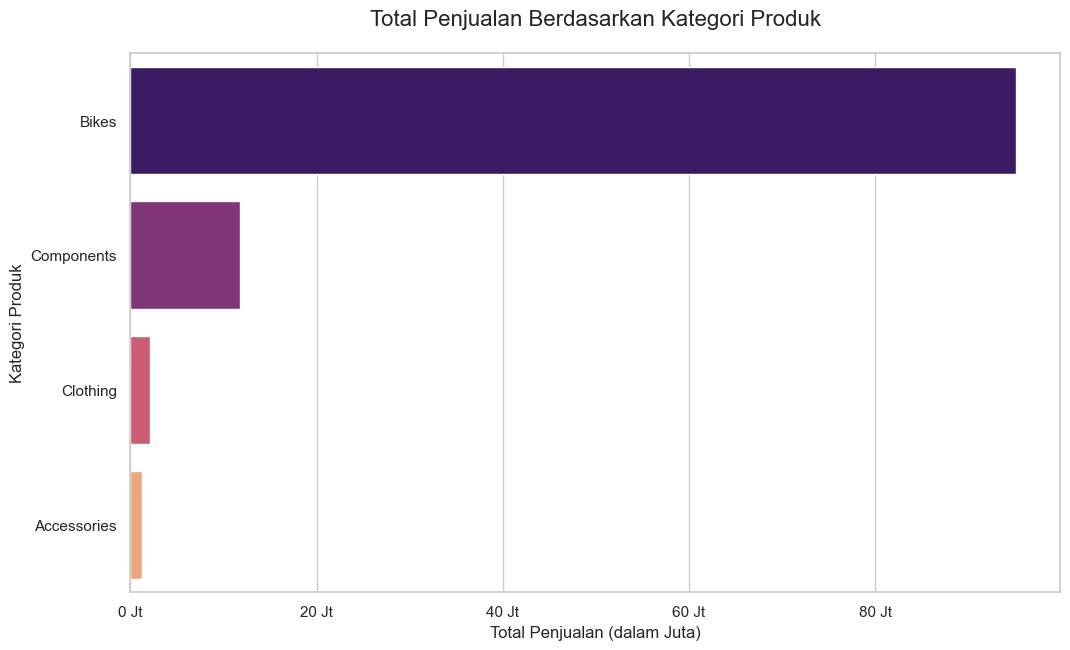


🎉🎉🎉 PROSES SELESAI!


In [8]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime # Import library datetime

# --- 1. KONEKSI (Sama seperti tadi) ---
db_user = 'postgres'; db_password = 'ardiwinata230803'; db_host = 'localhost'; db_port = '5432'
source_db_name = 'adventureworks_st'
target_db_name = 'adventureworks_wh'
source_conn_string = f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{source_db_name}"
source_engine = create_engine(source_conn_string)
target_conn_string = f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{target_db_name}"
target_engine = create_engine(target_conn_string)
print("✅ Koneksi berhasil!")

# --- 2. QUERY ANALISIS (Sama seperti tadi) ---
print("\nMenjalankan query analisis...")
query_kategori = """
SELECT dp.kategori, SUM(fp.total_harga) AS total_penjualan
FROM "Fakta_Penjualan" fp JOIN "Dim_Produk" dp ON fp.id_produk = dp.id_produk
GROUP BY dp.kategori ORDER BY total_penjualan DESC;
"""
df_kategori = pd.read_sql_query(query_kategori, source_engine)
print("✅ Query berhasil dieksekusi!")

# --- 3. TRANSFORMASI (Tambahkan Konteks Waktu) ---
# Ambil waktu saat ini sebagai penanda kapan laporan ini dibuat
waktu_laporan_dibuat = datetime.now()
df_kategori['tgl_laporan'] = waktu_laporan_dibuat
print(f"Menambahkan timestamp laporan: {waktu_laporan_dibuat}")

# --- 4. LOAD HASIL ANALISIS (Mode Append) ---
target_table_name = 'rpt_penjualan_per_kategori'
print(f"Menambahkan data ringkasan baru ke tabel '{target_table_name}'...")

# UBAH 'replace' MENJADI 'append'
df_kategori.to_sql(target_table_name, target_engine, if_exists='append', index=False)

print(f"✅ Tabel '{target_table_name}' berhasil ditambahkan {len(df_kategori)} baris data baru.")

# --- 5. VISUALISASI (Sama seperti tadi) ---
# (Kode untuk membuat plot dan menyimpan gambar tidak berubah)
print("\nMembuat visualisasi...")
plt.figure(figsize=(12, 7))
# ... (sisa kode plot sama persis) ...
barplot = sns.barplot(x='total_penjualan', y='kategori', data=df_kategori, palette='magma')
plt.title('Total Penjualan Berdasarkan Kategori Produk', fontsize=16, pad=20); plt.xlabel('Total Penjualan (dalam Juta)', fontsize=12); plt.ylabel('Kategori Produk', fontsize=12)
barplot.xaxis.set_major_formatter(lambda x, pos: f'{x/1e6:.0f} Jt')
output_folder = 'output'; os.makedirs(output_folder, exist_ok=True)
plt.savefig(os.path.join(output_folder, 'penjualan_per_kategori.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n🎉🎉🎉 PROSES SELESAI!")

✅ Koneksi ke database sumber 'adventureworks_st' berhasil!
✅ Koneksi ke database tujuan 'adventureworks_wh' berhasil!

--- Memulai Analisis 2: Tren Penjualan Bulanan ---
✅ Query tren penjualan berhasil dieksekusi!
Menambahkan timestamp laporan: 2025-06-19 22:14:05.454804
Menambahkan data ringkasan baru ke tabel 'rpt_tren_penjualan_bulanan' di database 'adventureworks_wh'...
✅ Tabel ringkasan 'rpt_tren_penjualan_bulanan' berhasil ditambahkan data baru.

Membuat visualisasi (Line Chart)...


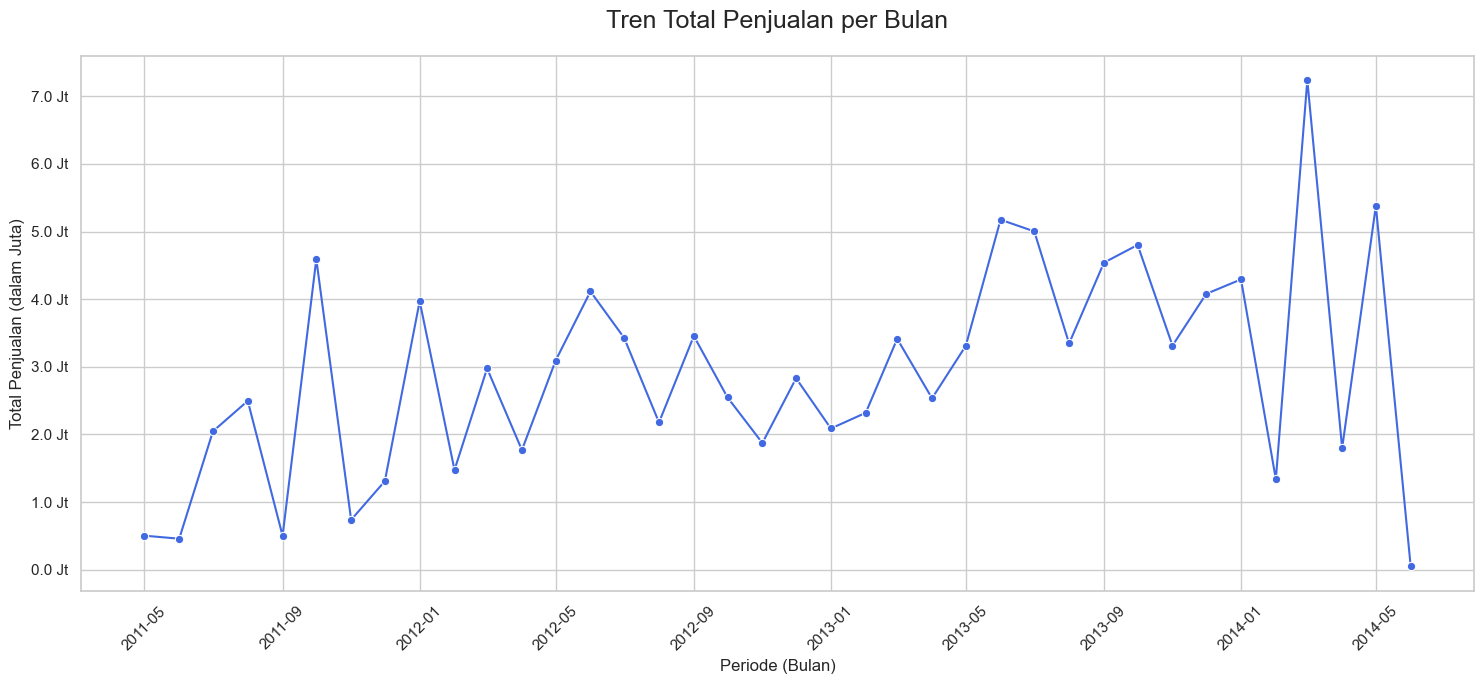


🎉 SUKSES! Grafik telah disimpan sebagai 'tren_penjualan_bulanan.png'.


In [10]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

# --- 1. KONEKSI KE DUA DATABASE ---
db_user = 'postgres'; db_password = 'ardiwinata230803'; db_host = 'localhost'; db_port = '5432'
source_db_name = 'adventureworks_st'
target_db_name = 'adventureworks_wh'

# Engine untuk membaca dari DWH Inti
source_conn_string = f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{source_db_name}"
source_engine = create_engine(source_conn_string)
print(f"✅ Koneksi ke database sumber '{source_db_name}' berhasil!")

# Engine untuk menulis ke Data Mart
target_conn_string = f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{target_db_name}"
target_engine = create_engine(target_conn_string)
print(f"✅ Koneksi ke database tujuan '{target_db_name}' berhasil!")


# --- 2. QUERY ANALISIS DARI DWH INTI ('_st') ---
print("\n--- Memulai Analisis 2: Tren Penjualan Bulanan ---")
query_tren = """
SELECT w.tahun, w.bulan, TO_DATE(w.tahun || '-' || w.bulan, 'YYYY-MM') AS periode, SUM(fp.total_harga) AS total_penjualan
FROM "Fakta_Penjualan" fp JOIN "Dim_Waktu" w ON fp.id_waktu = w.id_waktu
GROUP BY w.tahun, w.bulan ORDER BY w.tahun, w.bulan;
"""
df_tren = pd.read_sql_query(query_tren, source_engine)
print("✅ Query tren penjualan berhasil dieksekusi!")


# --- 3. TRANSFORMASI (Tambahkan Konteks Waktu) ---
waktu_laporan_dibuat = datetime.now()
df_tren['tgl_laporan'] = waktu_laporan_dibuat
print(f"Menambahkan timestamp laporan: {waktu_laporan_dibuat}")


# --- 4. LOAD HASIL ANALISIS KE DATA MART ('_wh') ---
target_table_name = 'rpt_tren_penjualan_bulanan'
print(f"Menambahkan data ringkasan baru ke tabel '{target_table_name}' di database '{target_db_name}'...")
df_tren.to_sql(target_table_name, target_engine, if_exists='append', index=False)
print(f"✅ Tabel ringkasan '{target_table_name}' berhasil ditambahkan data baru.")


# --- 5. VISUALISASI & SIMPAN GAMBAR ---
# (Kode visualisasi sama persis seperti sebelumnya)
print("\nMembuat visualisasi (Line Chart)...")
plt.figure(figsize=(15, 7)); lineplot = sns.lineplot(x='periode', y='total_penjualan', data=df_tren, marker='o', color='royalblue');
plt.title('Tren Total Penjualan per Bulan', fontsize=18, pad=20); plt.xlabel('Periode (Bulan)', fontsize=12); plt.ylabel('Total Penjualan (dalam Juta)', fontsize=12)
plt.xticks(rotation=45); lineplot.yaxis.set_major_formatter(lambda x, pos: f'{x/1e6:.1f} Jt'); plt.tight_layout()
output_folder = 'output'; plt.savefig(os.path.join(output_folder, 'tren_penjualan_bulanan.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"\n🎉 SUKSES! Grafik telah disimpan sebagai 'tren_penjualan_bulanan.png'.")

✅ Koneksi ke database berhasil!

--- Memulai Analisis 3: Top 10 Pelanggan ---
Menjalankan query untuk mencari pelanggan paling berharga...
✅ Query top 10 pelanggan berhasil dieksekusi!


,nama_lengkap,total_belanja
0,Roger Harui,882472.7866
1,Reuben D'sa,860147.5110
2,Andrew Dixon,853850.6395
3,Robert Vessa,817127.8029
4,Ryan Calafato,803769.8509
5,Joseph Castellucio,787808.8350
6,Kirk DeGrasse,751632.8575
7,Lindsey Camacho,741363.2168
8,Robin McGuigan,735235.7035
9,Stacey Cereghino,731636.8633



Menyimpan hasil ringkasan ke tabel 'rpt_top_10_pelanggan'...
✅ Tabel ringkasan 'rpt_top_10_pelanggan' berhasil ditambahkan data baru.

Membuat visualisasi (Horizontal Bar Chart)...


C:\Users\Pongo\AppData\Local\Temp\ipykernel_23784\2290937184.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


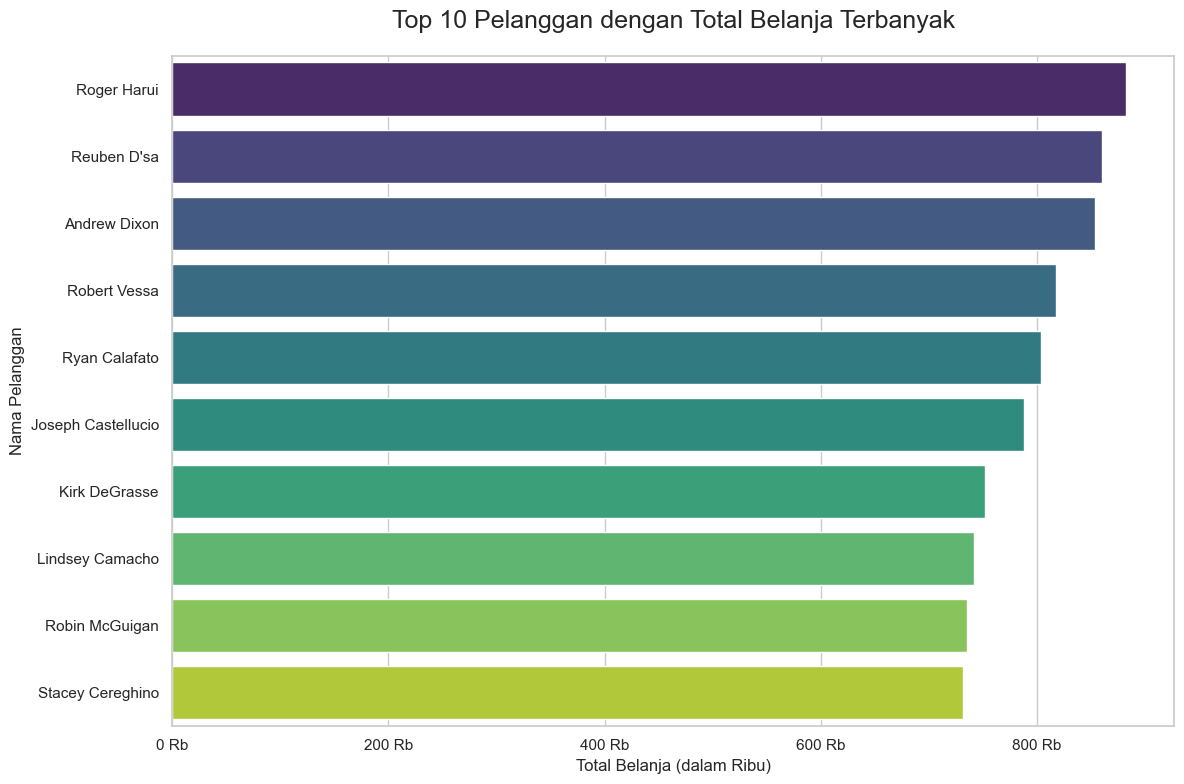


🎉 SUKSES! Grafik telah disimpan sebagai 'top_10_pelanggan.png'.


In [11]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

# --- 1. KONEKSI KE DATABASE ---
# Kita bisa pakai 'engine' yang sama dari sel sebelumnya
db_user = 'postgres'; db_password = 'ardiwinata230803'; db_host = 'localhost'; db_port = '5432'
source_db_name = 'adventureworks_st'
target_db_name = 'adventureworks_wh'
source_conn_string = f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{source_db_name}"
source_engine = create_engine(source_conn_string)
target_conn_string = f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{target_db_name}"
target_engine = create_engine(target_conn_string)

print("✅ Koneksi ke database berhasil!")

# --- 2. QUERY ANALISIS ---
print("\n--- Memulai Analisis 3: Top 10 Pelanggan ---")
print("Menjalankan query untuk mencari pelanggan paling berharga...")

# Query ini menggabungkan fakta dan dimensi pelanggan, lalu mencari top 10
# PERHATIKAN: Kita menggunakan "WHERE p.status_sekarang = TRUE" untuk memastikan kita hanya menganalisis data pelanggan yang aktif
query_top_cust = """
SELECT
    p.nama_lengkap,
    SUM(fp.total_harga) AS total_belanja
FROM "Fakta_Penjualan" fp
JOIN "Dim_Pelanggan" p ON fp.id_pelanggan = p.id_pelanggan
WHERE
    p.status_sekarang = TRUE -- Ini pentingnya SCD Tipe 2!
GROUP BY
    p.nama_lengkap
ORDER BY
    total_belanja DESC
LIMIT 10;
"""
df_top_cust = pd.read_sql_query(query_top_cust, source_engine)
print("✅ Query top 10 pelanggan berhasil dieksekusi!")
display(df_top_cust)

# --- 3. LOAD HASIL ANALISIS KE DATA MART ---
df_top_cust['tgl_laporan'] = datetime.now()
target_table_name = 'rpt_top_10_pelanggan'
print(f"\nMenyimpan hasil ringkasan ke tabel '{target_table_name}'...")
df_top_cust.to_sql(target_table_name, target_engine, if_exists='append', index=False)
print(f"✅ Tabel ringkasan '{target_table_name}' berhasil ditambahkan data baru.")

# --- 4. VISUALISASI ---
print("\nMembuat visualisasi (Horizontal Bar Chart)...")
plt.figure(figsize=(12, 8)) # Buat figur sedikit lebih tinggi
barplot = sns.barplot(
    x='total_belanja',
    y='nama_lengkap',
    data=df_top_cust,
    palette='viridis'
)
plt.title('Top 10 Pelanggan dengan Total Belanja Terbanyak', fontsize=18, pad=20)
plt.xlabel('Total Belanja (dalam Ribu)', fontsize=12)
plt.ylabel('Nama Pelanggan', fontsize=12)
barplot.xaxis.set_major_formatter(lambda x, pos: f'{(x/1e3):.0f} Rb')
plt.tight_layout()
output_folder = 'output'
plt.savefig(os.path.join(output_folder, 'top_10_pelanggan.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"\n🎉 SUKSES! Grafik telah disimpan sebagai 'top_10_pelanggan.png'.")